In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold

from utils import plot_confusion_matrix, OneHotEncoder

print(tf.__version__)
print(tf.keras.__version__)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
2.2.4-tf


Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [2]:
df = pd.read_csv('./slac/slac.csv', usecols = ['id','genre', 'subgenre', 'title'])
df

,id,genre,subgenre,title
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...,Blues,Modern,Born Under A Bad Sign
1,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get,Blues,Modern,How Blue Can You Get
2,Blues_-_Modern-B_B_King_-_Rock_Me_Baby,Blues,Modern,Rock Me Baby
3,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone,Blues,Modern,The Thrill Is Gone
4,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door,Blues,Modern,Don't Answer the Door
...,...,...,...,...
245,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...,Rock,Metal,Bulls On Parade
246,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...,Rock,Metal,Guerilla Radio
247,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...,Rock,Metal,Killing In The Name
248,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...,Rock,Metal,Know Your Enemy


We load the following kind of embeddings:
- complete
- without notes
- without program
- without tempo
- without time signature
- taking into account only the first 300 note groups

In [3]:
emb = KeyedVectors.load_word2vec_format('./slac/slac.bin')
emb_notes = KeyedVectors.load_word2vec_format('./slac/slac+notes.bin')
emb_program = KeyedVectors.load_word2vec_format('./slac/slac+program.bin')
emb_tempo = KeyedVectors.load_word2vec_format('./slac/slac+tempo.bin')
emb_ts = KeyedVectors.load_word2vec_format('./slac/slac+ts.bin')
emb_300 = KeyedVectors.load_word2vec_format('./slac/slac_300.bin')

In [4]:
ids = df.id.tolist()
data = np.array([emb[i] for i in ids])
data_notes = np.array([emb_notes[i] for i in ids])
data_program = np.array([emb_program[i] for i in ids])
data_tempo = np.array([emb_tempo[i] for i in ids])
data_ts = np.array([emb_ts[i] if i in emb_ts else np.zeros(100) for i in ids ])
data_300 = np.array([emb_300[i] for i in ids])

In [5]:
emb_sets = {
    'ALL' : data,
    '+N': data_notes,
    '+P': data_program,
    '+T': data_tempo,
    '+TS': data_ts,
    '300': data_300
}

### Experiment 1: Genres 

The labels are represented with the 1-hot encoding

In [6]:
onehot = OneHotEncoder(df.genre.tolist())

onehot.get(onehot.labels[0])

'Blues'

In [7]:
data.shape

(250, 100)

In [8]:
onehot.labels.shape

(250, 5)

In [9]:
num_input = data.shape[1]
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [10]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model

In [11]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=10, 
                                 batch_size=50, verbose=0)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [12]:
random_state = 2111
scores_5c = {}
for name, d in emb_sets.items():
    print(name)
    scores = cross_val_score(neural_network, d, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
    print(scores)
    scores_5c[name] = np.mean(scores)
scores_5c

W0624 11:44:29.668111 4611612096 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ALL
[0.88       0.88       0.92000002 0.88       0.88       0.95999998
 0.83999997 0.88       0.75999999 0.75999999]
+N
[0.83999997 0.83999997 0.80000001 0.92000002 0.88       0.83999997
 0.80000001 0.83999997 0.60000002 0.80000001]
+P
[0.83999997 0.72000003 0.75999999 0.80000001 0.68000001 0.72000003
 0.80000001 0.92000002 0.88       0.83999997]
+T
[0.28       0.28       0.28       0.12       0.36000001 0.40000001
 0.12       0.36000001 0.28       0.23999999]
+TS
[0.31999999 0.23999999 0.28       0.2        0.16       0.36000001
 0.16       0.28       0.2        0.36000001]
300
[0.92000002 0.72000003 0.83999997 0.75999999 0.83999997 0.95999998
 0.72000003 0.72000003 0.68000001 0.75999999]


{'ALL': 0.863999992609024,
 '+N': 0.8159999966621398,
 '+P': 0.7960000038146973,
 '+T': 0.27200000286102294,
 '+TS': 0.2560000017285347,
 '300': 0.79200000166893}

In [13]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

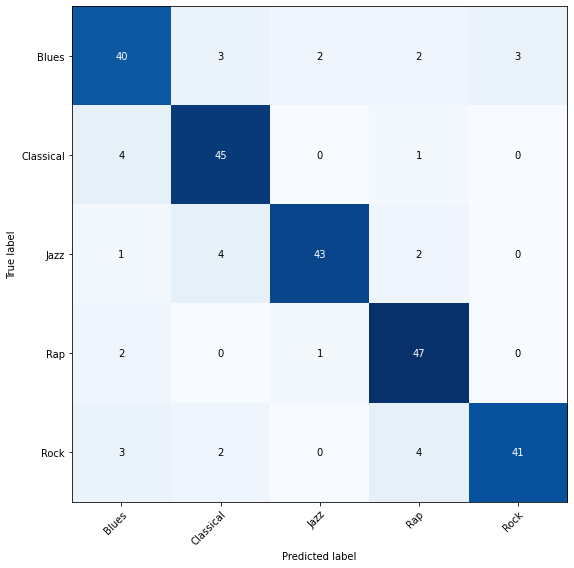

In [14]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre.tolist(), title='genre')

#### Normalized confusion matrix

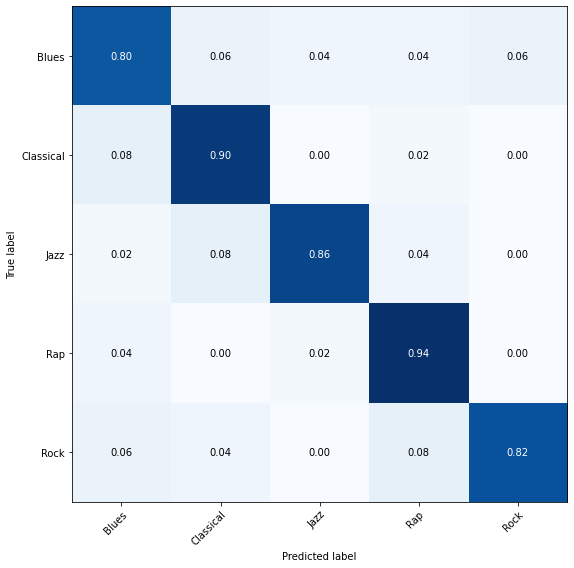

In [15]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre.tolist(), normalize=True, title='genre')

### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [16]:
onehot = OneHotEncoder(df.subgenre.tolist())
    
onehot.get(onehot.labels[0])

'Modern'

In [17]:
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 10)

In [18]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [32]:
random_state = 2111
scores_10c = {}
for name, d in emb_sets.items():
    print(name)
    scores = cross_val_score(neural_network, d, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
    print(scores)
    scores_10c[name] = np.mean(scores)
scores_10c

ALL
[0.47999999 0.63999999 0.72000003 0.72000003 0.63999999 0.83999997
 0.68000001 0.68000001 0.56       0.56      ]
+N
[0.60000002 0.56       0.60000002 0.88       0.68000001 0.60000002
 0.63999999 0.51999998 0.56       0.68000001]
+P
[0.60000002 0.60000002 0.47999999 0.51999998 0.47999999 0.56
 0.60000002 0.47999999 0.44       0.63999999]
+T
[0.12       0.2        0.28       0.08       0.16       0.23999999
 0.2        0.04       0.16       0.12      ]
+TS
[0.16       0.16       0.08       0.16       0.16       0.23999999
 0.04       0.2        0.08       0.12      ]
300
[0.72000003 0.51999998 0.56       0.51999998 0.60000002 0.63999999
 0.51999998 0.51999998 0.44       0.56      ]


{'ALL': 0.6520000010728836,
 '+N': 0.6320000052452087,
 '+P': 0.5400000005960465,
 '+T': 0.1599999986588955,
 '+TS': 0.13999999761581422,
 '300': 0.5599999964237213}

In [33]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

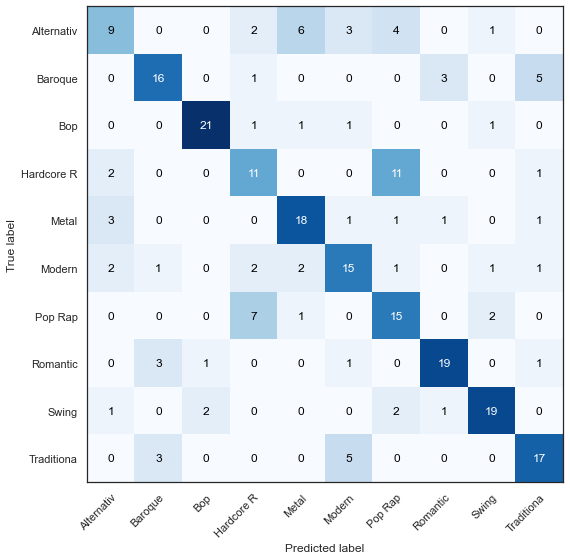

In [34]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.subgenre.tolist(), title="subgenre")

#### Normalized confusion matrix

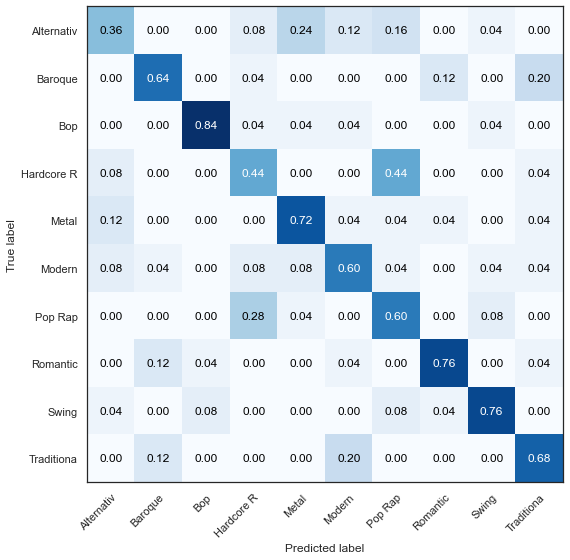

In [35]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.subgenre.tolist(), normalize=True, title="subgenre")

Export the results for publication

In [36]:
res = pd.DataFrame.from_dict(scores_5c.items())
res.columns=['Approach', '5 classes']
res['10 classes'] = scores_10c.values()
res

,Approach,5 classes,10 classes
0,ALL,0.864,0.652
1,+N,0.816,0.632
2,+P,0.796,0.540
3,+T,0.272,0.160
4,+TS,0.256,0.140
5,300,0.792,0.560


In [37]:
res.to_latex('output/slac.classification.latex',index=False)

# 2D Visualisation with TSNE

Picture saved at ./img/tsne-slac-genre.pdf


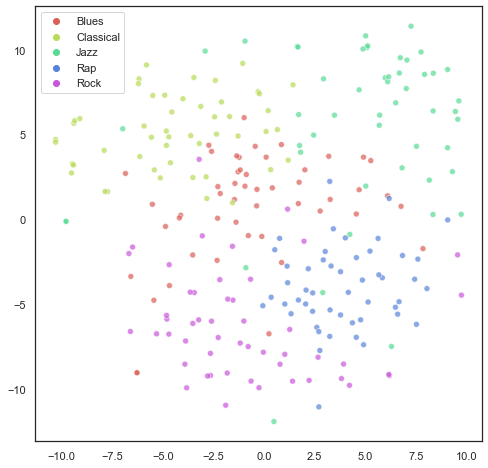

In [38]:
from utils import plot
plot(data, labels=df.genre.tolist(), output='./img/tsne-slac-genre.pdf')

Picture saved at ./img/tsne-slac-subgenre.pdf


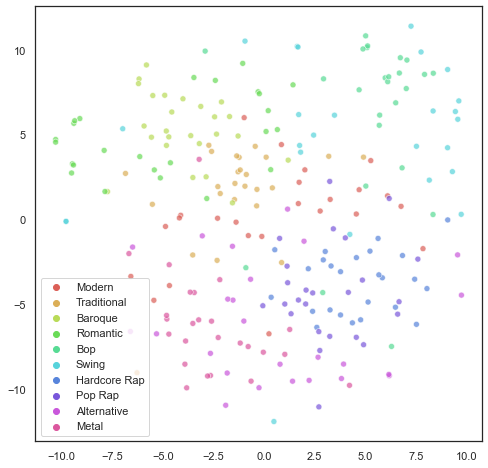

In [39]:
plot(data, labels=df.subgenre.tolist(), output='./img/tsne-slac-subgenre.pdf')